Nodes with highest degree centrality: [(4187438672, 8), (912298892, 8), (912287486, 8), (3783691645, 8), (318694398, 8)]
Nodes with highest closeness centrality: [(912287486, 0.000192), (912311207, 0.000191), (2143843981, 0.000191), (2078574783, 0.000191), (1946089897, 0.000191)]
Nodes with highest betweenness centrality: [(912287486, 0.10457), (912306334, 0.101021), (1875944482, 0.099769), (375694255, 0.099472), (318694350, 0.099057)]
2113
[(375694438, 4230598315, 0), (375694438, 375694362, 0), (375694438, 375694984, 0), (4230598315, 375694438, 0), (4230598315, 4537840691, 0)]
Edges with highest edge betweenness centrality: [((912305827, 665371479), 0.057043), ((665371479, 5774515722), 0.056402), ((665371476, 912305827), 0.056246), ((5774515722, 1875944482), 0.056179), ((1875944482, 2142859863), 0.05392)]
Number of Strongly Connected Components: 327


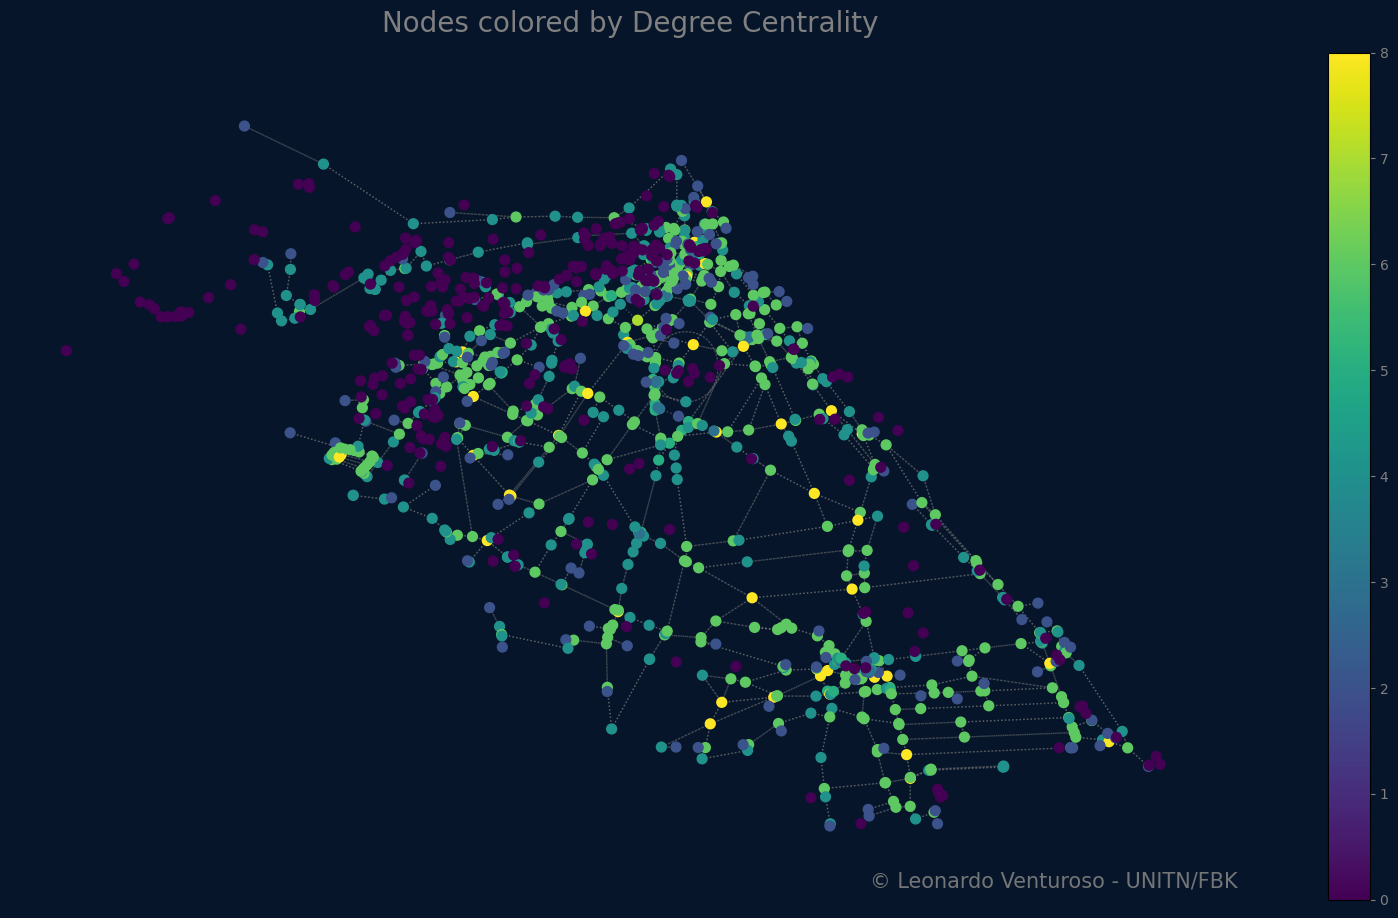

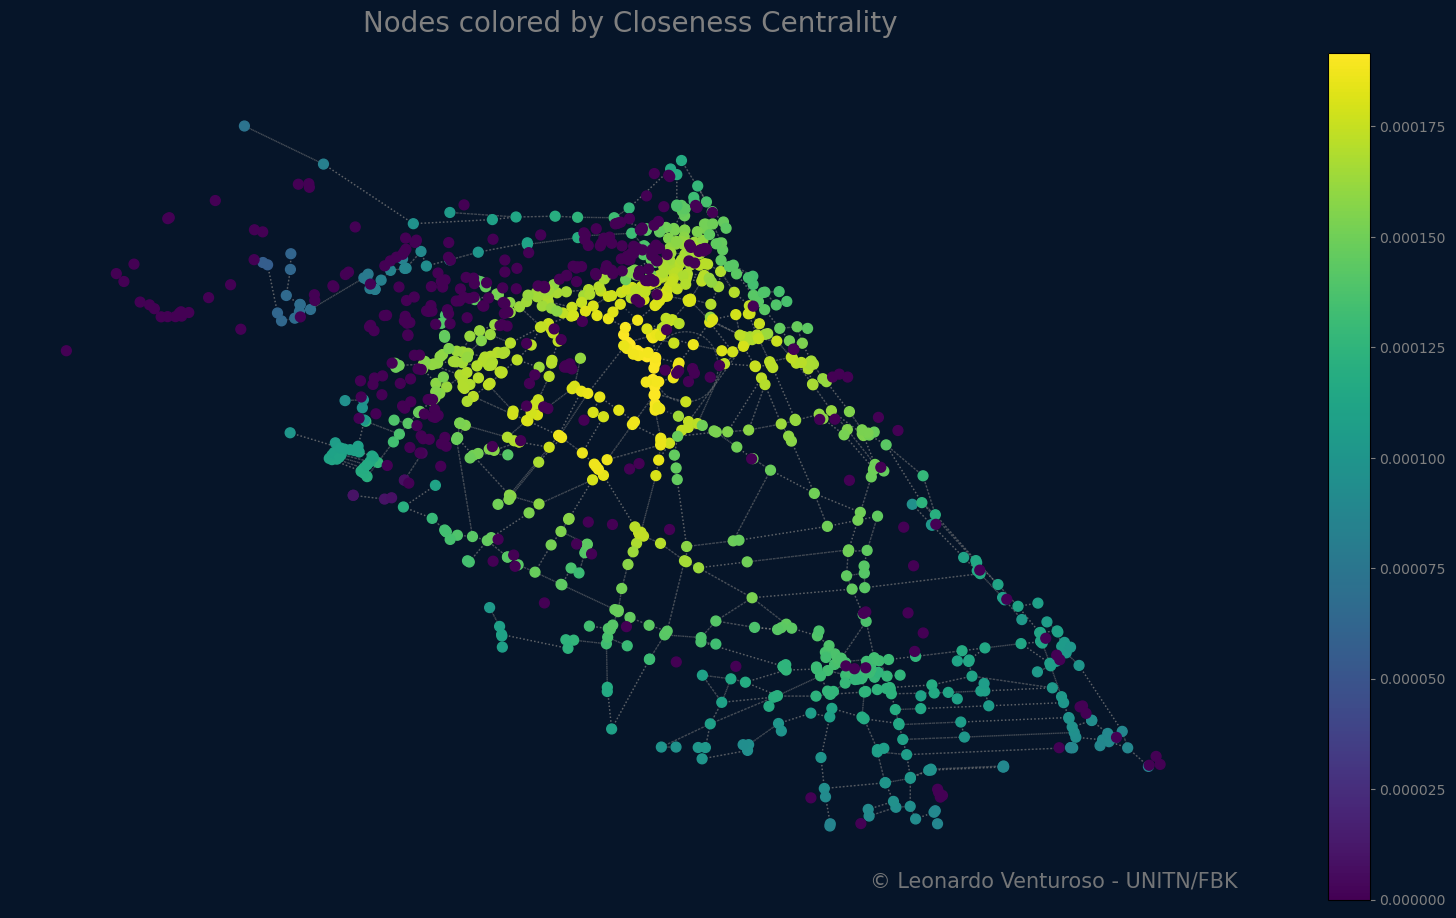

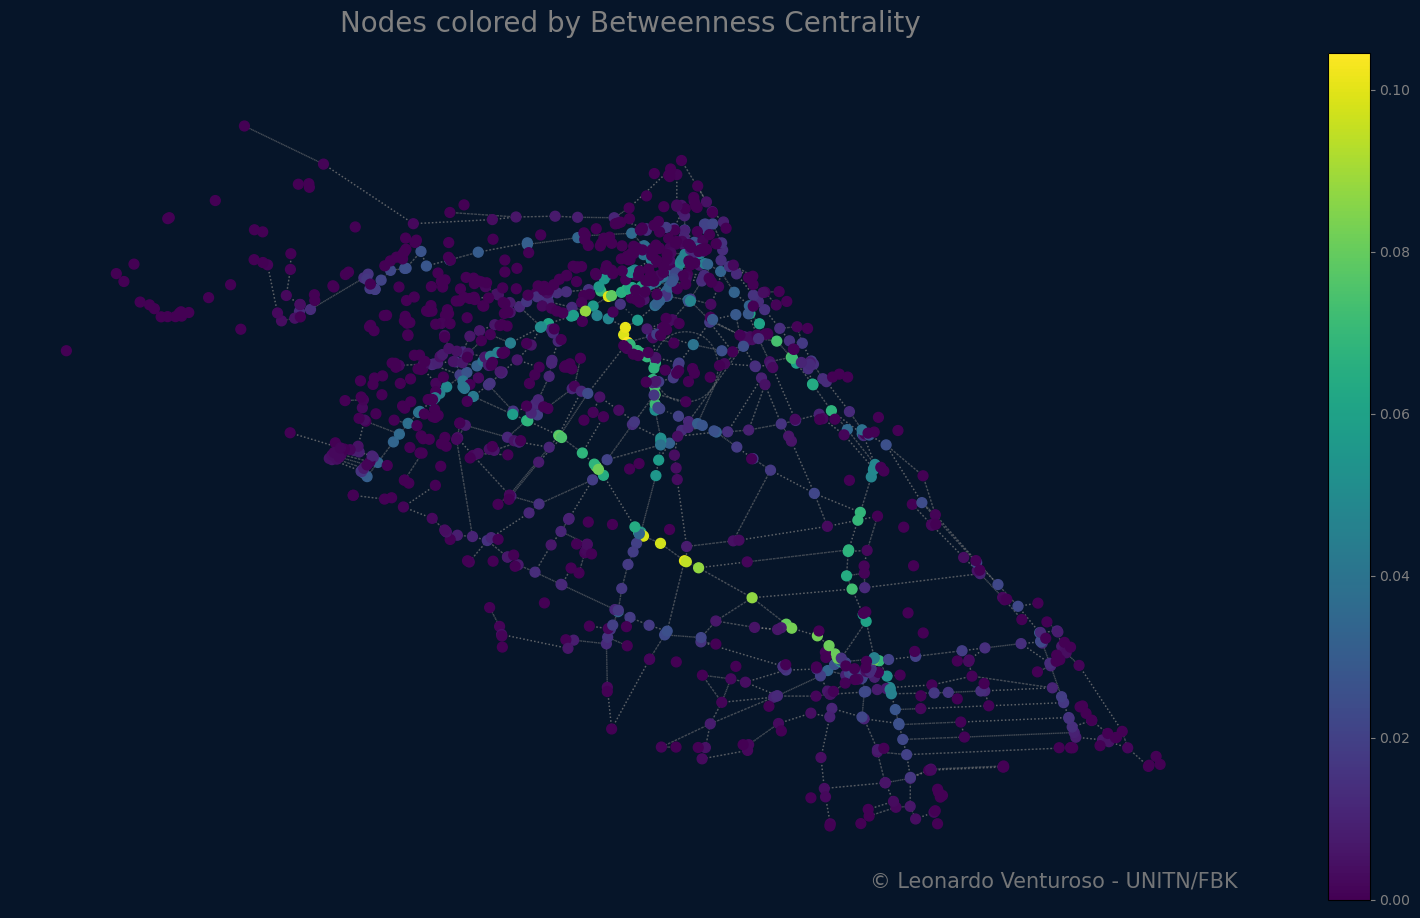

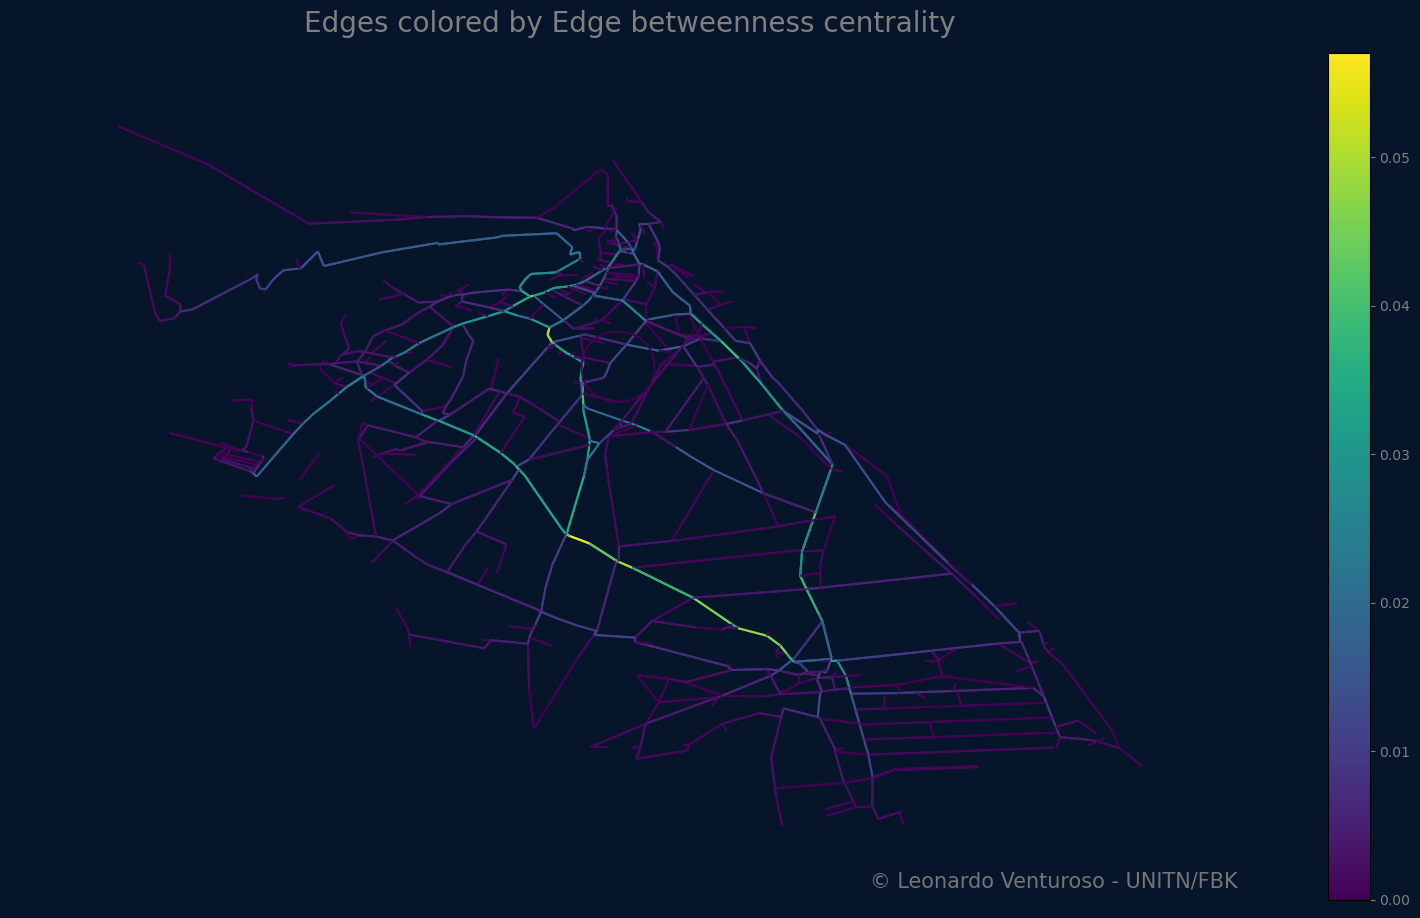

In [1]:
# Network Analysis

import osmnx as ox
import networkx as nx
from shapely.geometry import Point
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import collections
import matplotlib.patches as mpatches

# Load data
filepath = "/Users/leonardo/Desktop/Tesi/LTSBikePlan/data/Montereale_Valcellina_lts.graphml"
G_lts = ox.load_graphml(filepath)
G_lts = ox.project_graph(G_lts, to_crs='EPSG:4326')
crs = G_lts.graph['crs']


def degree_centrality(G):
    """Calculate degree centrality."""
    return {node: G.degree(node) for node, data in G.nodes(data=True)}

def closeness_centrality(G):
    """Calculate closeness centrality."""
    return nx.closeness_centrality(G, distance='length')

def betweenness_centrality(G):
    """Calculate betweenness centrality."""
    return nx.betweenness_centrality(G, weight='length')

# Calculate degree centrality
degree_centrality_values = degree_centrality(G_lts)

# Nodes with highest degree centrality (top 5)
top_degree_nodes = sorted(degree_centrality_values.items(), key=lambda x: x[1], reverse=True)[:5]

# Closeness Centrality
closeness_centrality_values = closeness_centrality(G_lts)
top_closeness_nodes = sorted(closeness_centrality_values.items(), key=lambda x: x[1], reverse=True)[:5]
# Round the values of the second term
top_closeness_nodes_rounded = [(node, round(value, 6)) for node, value in top_closeness_nodes]

# Betweenness Centrality
betweenness_centrality_values = betweenness_centrality(G_lts)
top_betweenness_nodes = sorted(betweenness_centrality_values.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness_nodes_rounded = [(node, round(value, 6)) for node, value in top_betweenness_nodes]

print("Nodes with highest degree centrality:", top_degree_nodes)
print("Nodes with highest closeness centrality:", top_closeness_nodes_rounded)
print("Nodes with highest betweenness centrality:", top_betweenness_nodes_rounded)

def edge_betweenness_centrality(G):
    """Calculate edge betweenness centrality."""
    return nx.edge_betweenness_centrality(G, weight='length')

# Edge Betweenness Centrality
edge_betweenness_centrality_values = edge_betweenness_centrality(G_lts)
print(len(edge_betweenness_centrality_values))
print(list(edge_betweenness_centrality_values.keys())[:5])
top_edge_betweenness = sorted(edge_betweenness_centrality_values.items(), key=lambda x: x[1], reverse=True)[:5]
top_edge_betweenness_rounded = [((u, v), round(value, 6)) for (u, v, *_) , value in top_edge_betweenness]

print("Edges with highest edge betweenness centrality:", top_edge_betweenness_rounded)

# Identify strongly connected components - SCCs
sccs = list(nx.strongly_connected_components(G_lts))
print(f"Number of Strongly Connected Components: {len(sccs)}")

def draw_graph(G, centrality_values, title):
    # Filter out nodes that don't have centrality values
    nodes_to_include = [node for node in G.nodes() if node in centrality_values]
    subgraph = G.subgraph(nodes_to_include)
    
    # Use geographical coordinates for positioning
    pos = {node: (data['x'], data['y']) for node, data in subgraph.nodes(data=True)}
    
    node_colors = [centrality_values[node] for node in subgraph.nodes()]
    
    # Figure setup
    fig, ax = plt.subplots(figsize=(20,11))
    ax.set_facecolor("#061529")
    fig.set_facecolor("#061529")
    
    # Color scale
    cmap = plt.cm.viridis
    vmin = min(node_colors)
    vmax = max(node_colors)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = plt.colorbar(sm)
    cbar.ax.yaxis.set_tick_params(color='grey')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='grey')
    
    # Draw nodes and edges
    nx.draw_networkx_nodes(G=subgraph, pos=pos, node_color=node_colors, cmap=cmap, alpha=1, node_size=50)
    nx.draw_networkx_edges(G=subgraph, pos=pos, edge_color='grey', style="dotted", alpha=0.5, arrows=False)
    
    # Labeling Axes
    ax.set_title(title, fontdict={"fontsize":20, "color": "grey"}, pad=15)
    ax.axis('off')
    

    # Watermark
    ax.text(0.99, 0.01, '© Leonardo Venturoso - UNITN/FBK',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha=0.9)
    
    plt.show()

## Visualize nodes based on Degree Centrality
draw_graph(G_lts, degree_centrality_values, 'Nodes colored by Degree Centrality')

## Visualize nodes based on Closeness Centrality
draw_graph(G_lts, closeness_centrality_values, 'Nodes colored by Closeness Centrality')

## Visualize nodes based on Betweenness Centrality
draw_graph(G_lts, betweenness_centrality_values, 'Nodes colored by Betweenness Centrality')


def draw_edges(G, centrality_values, title):
    # 1. Identify common edges between G and centrality_values
    common_edges = set(G.edges()).intersection(set(centrality_values.keys()))
    
    # 2. Construct the edge colors by accommodating both edge orientations
    edge_colors = [centrality_values[edge] if edge in centrality_values else centrality_values[(edge[1], edge[0])] for edge in common_edges]
    
    # Use geographical coordinates for positioning
    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
    
    # Figure setup
    fig, ax = plt.subplots(figsize=(20, 11))
    ax.set_facecolor("#061529")
    fig.set_facecolor("#061529")
    
    # Color scale
    cmap = plt.cm.viridis
    vmin = min(edge_colors)
    vmax = max(edge_colors)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = plt.colorbar(sm)
    cbar.ax.yaxis.set_tick_params(color='grey')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='grey')
    
    # Draw edges with their centrality values
    nx.draw_networkx_edges(G, pos, edgelist=common_edges, edge_color=edge_colors, edge_cmap=cmap, alpha=1, width=1.5, arrows=False)
    
    # Labeling Axes
    ax.set_title(title, fontdict={"fontsize": 20, "color": "grey"}, pad=15)
    ax.axis('off')
    
    # Watermark
    ax.text(0.99, 0.01, '© Leonardo Venturoso - UNITN/FBK',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha=0.9)
    
    plt.show()

# Call the function to visualize
fixed_edge_betweenness = {(u, v): value for (u, v, *_), value in edge_betweenness_centrality_values.items()}
draw_edges(G_lts, fixed_edge_betweenness, "Edges colored by Edge betweenness centrality")



High-stress nodes: [912306659, 912298106, 9407403115, 3445307007, 912292632, 4417658388, 375694262, 275047641, 6532857567, 912303265, 912298815, 6532722874, 275047646, 1812883495, 3493141395, 1812883498, 912285250, 275047789, 1812888011, 3741329882, 3741329912, 295257285, 275047807, 912298224, 912293688, 912302747, 778888939, 912305093, 275048618, 1902148479, 1902148592, 912298892, 912294208, 912295544, 275048626, 912285611, 912296850, 912305987, 3710631528, 2465682443, 275052691, 3471819403, 2208780228, 912283507, 6514628942, 4109186227, 295279410, 912294506, 2142860777, 912282927, 318694369, 3481947933, 1865801228, 912298234, 912295039, 318694398, 912282520, 912298174, 912289270, 4007156374, 318694413, 912302147, 912296263, 1865801254, 326044370, 326044388, 1711192659, 326044650, 3137433200, 3647507513, 375693963, 912302191, 912311114, 912283315, 1812883484, 912304459, 11020585071, 375694255, 492115024, 912307782, 1812883474, 912303842, 6684822552, 912312119, 402579041, 402579695, 40

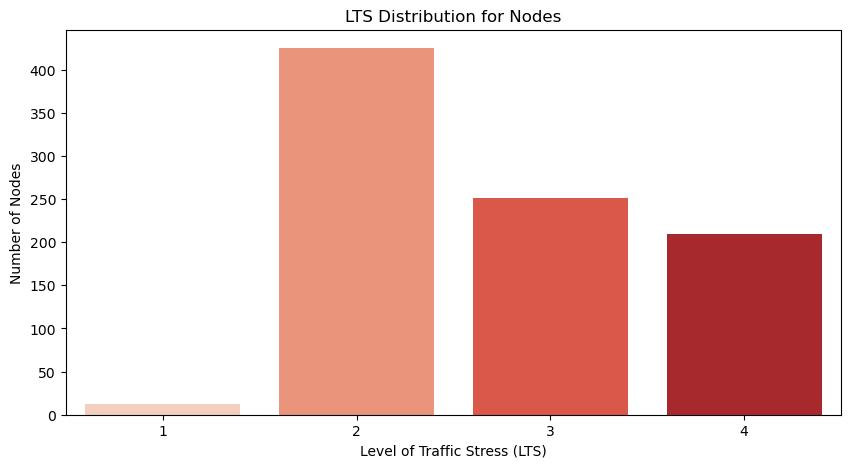

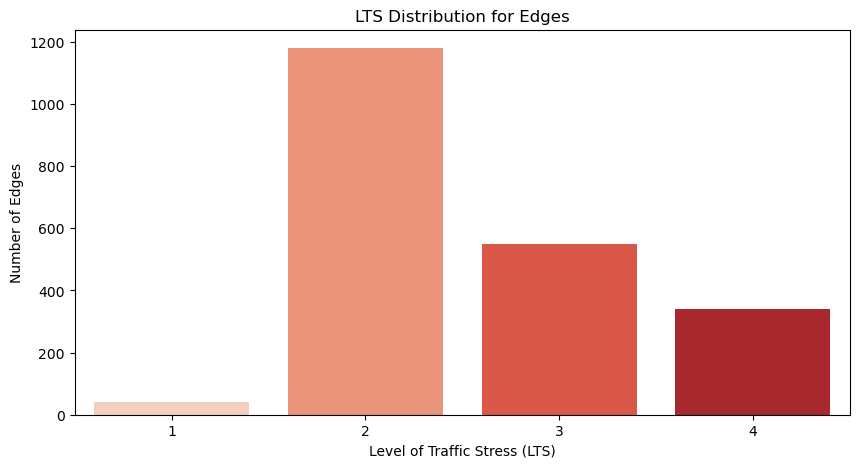

Nodes - Mean LTS: 2.73, Median LTS: 3.0, Standard Deviation: 0.83
Edges - Mean LTS: 2.56, Median LTS: 2.0, Standard Deviation: 0.78


In [2]:
# Geospatial Analysis

import warnings

# Suppress specific warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Identify nodes (intersections) with the highest LTS.

## Nodes with highest LTS
high_stress_nodes = [node for node, data in G_lts.nodes(data=True) if 'lts' in data and data['lts'] == '4']

## Identify roads (edges) with the highest LTS.
high_stress_edges = [(u, v) for u, v, data in G_lts.edges(data=True) if 'lts' in data and data['lts'] == '4']

print(f"High-stress nodes: {high_stress_nodes}")
print(f"High-stress edges: {high_stress_edges}")
print(f"Number of high-stress nodes: {len(high_stress_nodes)}")
print(f"Number of high-stress edges: {len(high_stress_edges)}")

## Calculate the average LTS for the entire network.

## Convert LTS values to integers for calculation, ensuring the 'lts' attribute exists
lts_values_nodes = [int(data['lts']) for _, data in G_lts.nodes(data=True) if 'lts' in data]
lts_values_edges = [int(data['lts']) for _, _, data in G_lts.edges(data=True) if 'lts' in data]

## Distribution of the Level of Traffic Stress (LTS) among nodes and edges.
from collections import Counter

## Count the frequency of each LTS value for nodes and edges
lts_node_freq = Counter(lts_values_nodes)
lts_edge_freq = Counter(lts_values_edges)

## Order the Counter objects by their keys
lts_node_freq = dict(sorted(lts_node_freq.items()))
lts_edge_freq = dict(sorted(lts_edge_freq.items()))

print("Ordered LTS distribution for nodes:", lts_node_freq)
print("Ordered LTS distribution for edges:", lts_edge_freq)

## Plot for nodes
plt.figure(figsize=(10, 5))
sns.countplot(lts_values_nodes, palette="Reds", order=sorted(set(lts_values_nodes)))
plt.xlabel('Level of Traffic Stress (LTS)')
plt.ylabel('Number of Nodes')
plt.title('LTS Distribution for Nodes')
plt.show()

## Plot for edges
plt.figure(figsize=(10, 5))
sns.countplot(lts_values_edges, palette="Reds", order=sorted(set(lts_values_edges)))
plt.xlabel('Level of Traffic Stress (LTS)')
plt.ylabel('Number of Edges')
plt.title('LTS Distribution for Edges')
plt.show()

## Descriptive Statistic about LTS - Nodes & Edges
mean_lts_nodes = np.mean(lts_values_nodes)
median_lts_nodes = np.median(lts_values_nodes)
std_dev_lts_nodes = np.std(lts_values_nodes)

mean_lts_edges = np.mean(lts_values_edges)
median_lts_edges = np.median(lts_values_edges)
std_dev_lts_edges = np.std(lts_values_edges)

print(f"Nodes - Mean LTS: {round(mean_lts_nodes,2)}, Median LTS: {round(median_lts_nodes,2)}, Standard Deviation: {round(std_dev_lts_nodes,2)}")
print(f"Edges - Mean LTS: {round(mean_lts_edges,2)}, Median LTS: {round(median_lts_edges,2)}, Standard Deviation: {round(std_dev_lts_edges,2)}")


In [3]:
# Network Analysis

## Calculate centrality measures to identify important nodes (intersections) in the network.

def lts_weighted_degree_centrality(G):
    """Calculate degree centrality weighted by LTS."""
    return {node: G.degree(node) * int(data['lts']) for node, data in G.nodes(data=True) if 'lts' in data}

def lts_weighted_closeness_centrality(G):
    """Calculate closeness centrality weighted by LTS."""
    for u, v, data in G.edges(data=True):
        data['lts_weight'] = data['length'] / int(data['lts'])
    return nx.closeness_centrality(G, distance='lts_weight')

def lts_weighted_betweenness_centrality(G):
    """Calculate betweenness centrality weighted by LTS."""
    for u, v, data in G.edges(data=True):
        data['lts_weight'] = data['length'] / int(data['lts'])
    return nx.betweenness_centrality(G, weight='lts_weight')


## Calculate degree centrality
degree_centrality = lts_weighted_degree_centrality(G_lts)

## Nodes with highest degree centrality (top 5)
top_degree_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

## Closeness Centrality
closeness_centrality = lts_weighted_closeness_centrality(G_lts)
top_closeness_nodes = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
# Round the values of the second term
top_closeness_nodes_rounded = [(node, round(value, 6)) for node, value in top_closeness_nodes]

## Betweenness Centrality
betweenness_centrality = lts_weighted_betweenness_centrality(G_lts)
top_betweenness_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness_nodes_rounded = [(node, round(value, 6)) for node, value in top_betweenness_nodes]

print("Nodes with highest degree centrality:", top_degree_nodes)
print("Nodes with highest closeness centrality:", top_closeness_nodes_rounded)
print("Nodes with highest betweenness centrality:", top_betweenness_nodes_rounded)

## Centrality measures for important edges:
def lts_weighted_edge_betweenness_centrality(G):
    """Calculate edge betweenness centrality weighted by LTS."""
    # Update the graph with the new weighted lengths
    for u, v, data in G.edges(data=True):
        data['lts_weight'] = data['length'] / int(data['lts'])
    return nx.edge_betweenness_centrality(G, weight='lts_weight')

## Edge Betweenness Centrality
edge_betweenness_centrality = lts_weighted_edge_betweenness_centrality(G_lts)
top_edge_betweenness = sorted(edge_betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_edge_betweenness_rounded = [((u, v), round(value, 6)) for (u, v, *_) , value in top_edge_betweenness]

print("Edges with highest betweenness centrality:", top_edge_betweenness_rounded)

## Identify strongly connected components - SCCs, since graph is directed. A strongly connected component of a directed graph 
## is a maximal strongly connected subgraph.That is, it's a subgraph where every vertex is reachable from every other vertex in the subgraph.

sccs = list(nx.strongly_connected_components(G_lts))
print(f"Number of Strongly Connected Components: {len(sccs)}")

## High-Stress Subgraphs: Identify subgraphs (connected components) of the network that have a high average LTS (LTS = 4). 
## This can help in pinpointing areas that are particularly stressful for cyclists or pedestrians.

# First, create a subgraph with only edges having LTS = 4
high_stress_edges = [(u, v, k) for u, v, k, d in G_lts.edges(keys=True, data=True) if 'lts' in d and d.get('lts') == '4']
G_high_stress = G_lts.edge_subgraph(high_stress_edges)

# Then, identify the connected components of this subgraph
high_stress_subgraphs = list(nx.strongly_connected_components(G_high_stress))
print(f"Number of High-Stress Subgraphs: {len(high_stress_subgraphs)}")


Nodes with highest degree centrality: [(912298892, 32), (318694398, 32), (912296263, 32), (375693963, 32), (912303842, 32)]
Nodes with highest closeness centrality: [(295279410, 0.00055), (2980754259, 0.000549), (912306120, 0.000548), (912289180, 0.000547), (2078574772, 0.000547)]
Nodes with highest betweenness centrality: [(2142859863, 0.15321), (665371479, 0.152969), (5774515722, 0.152044), (1875944482, 0.151747), (665371590, 0.148422)]
Edges with highest betweenness centrality: [((912305827, 665371479), 0.079024), ((665371479, 5774515722), 0.078355), ((5774515722, 1875944482), 0.078101), ((1875944482, 2142859863), 0.077995), ((2142859863, 665371590), 0.075532)]
Number of Strongly Connected Components: 327
Number of High-Stress Subgraphs: 42


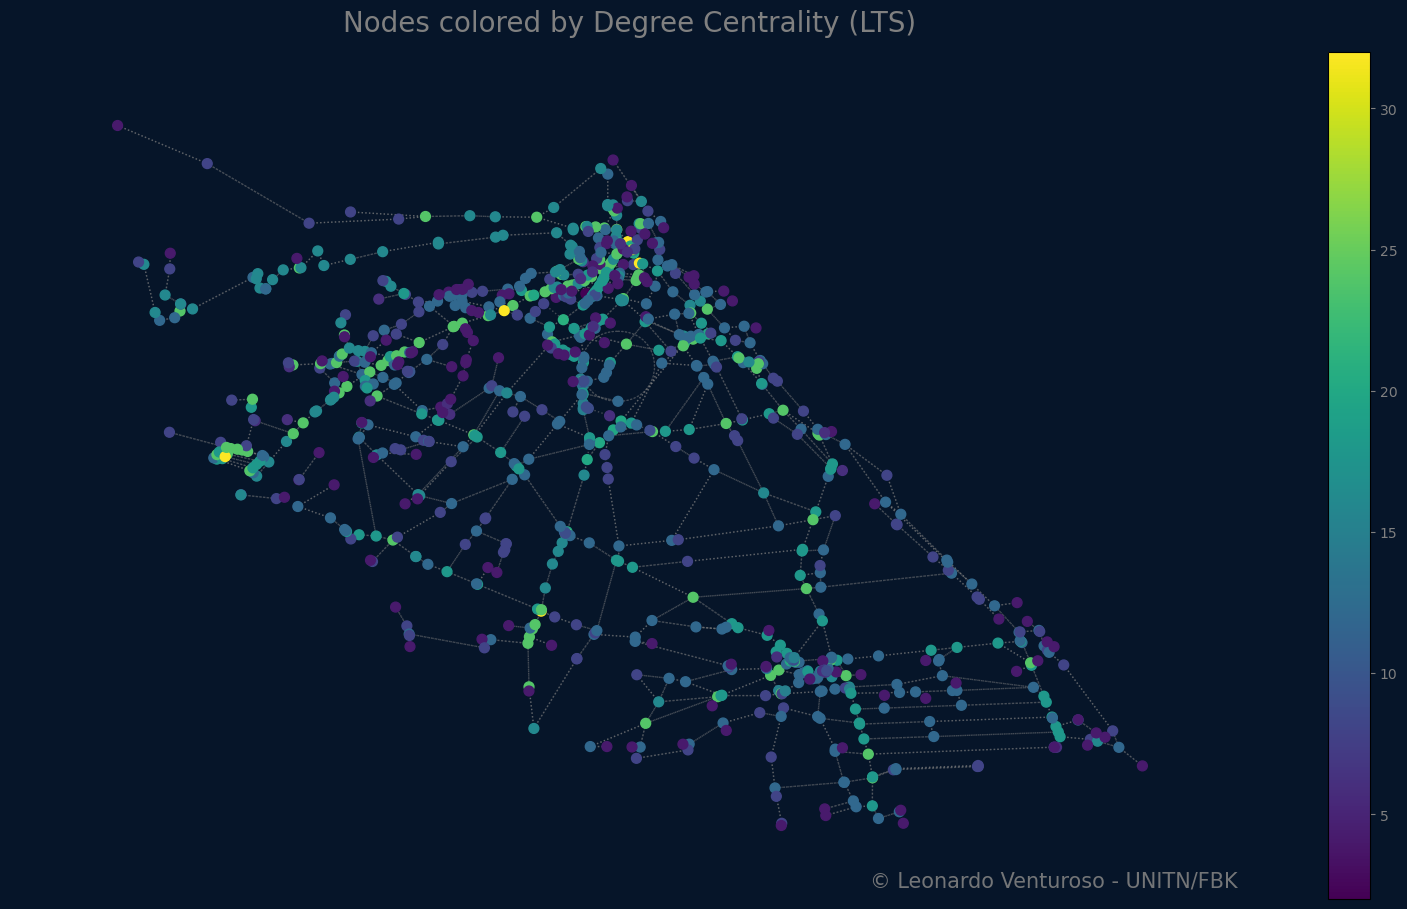

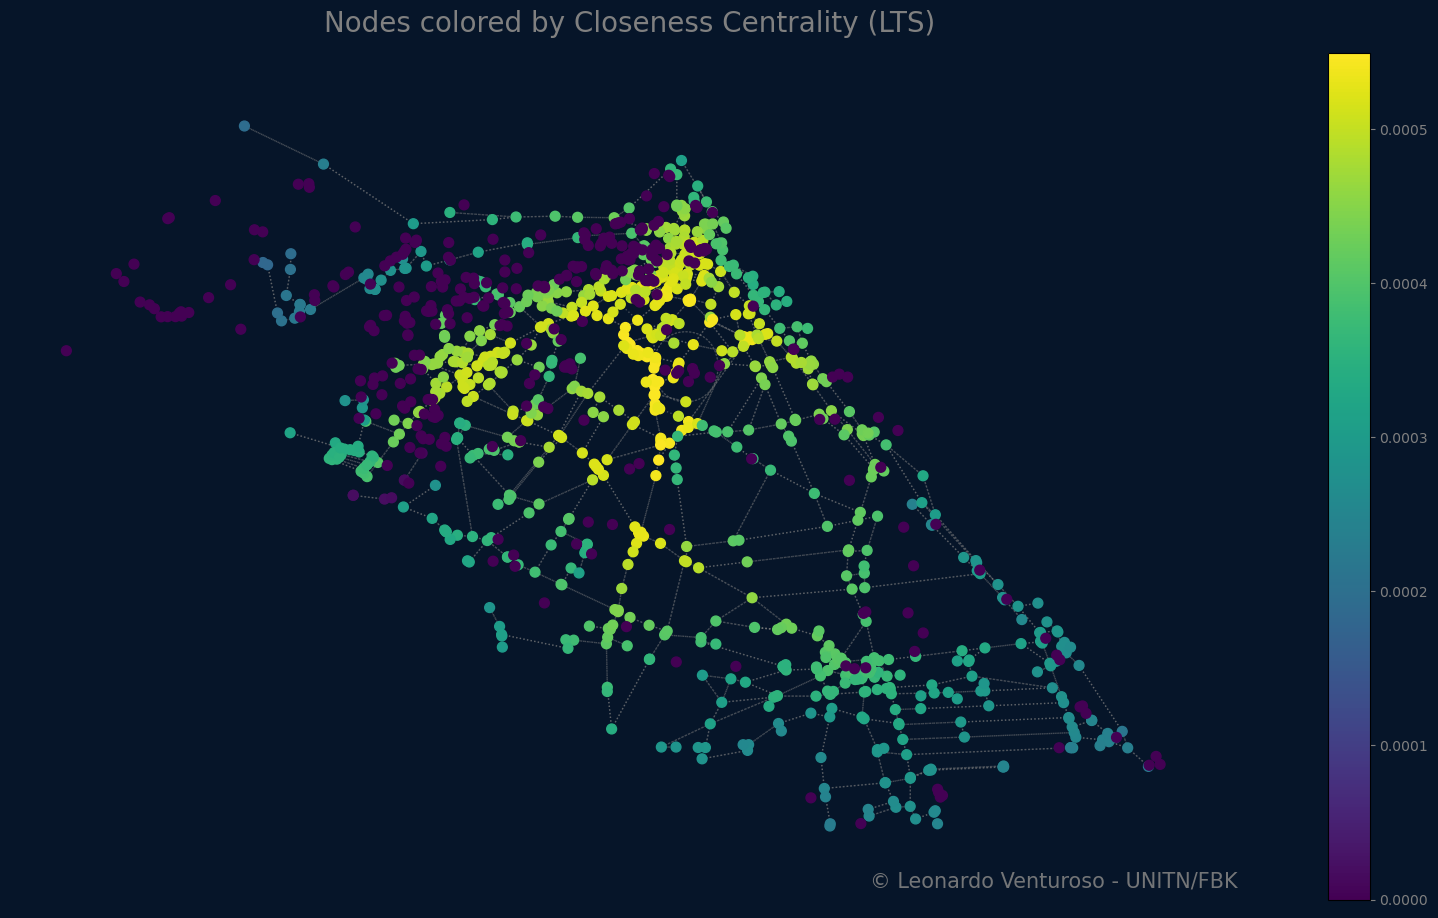

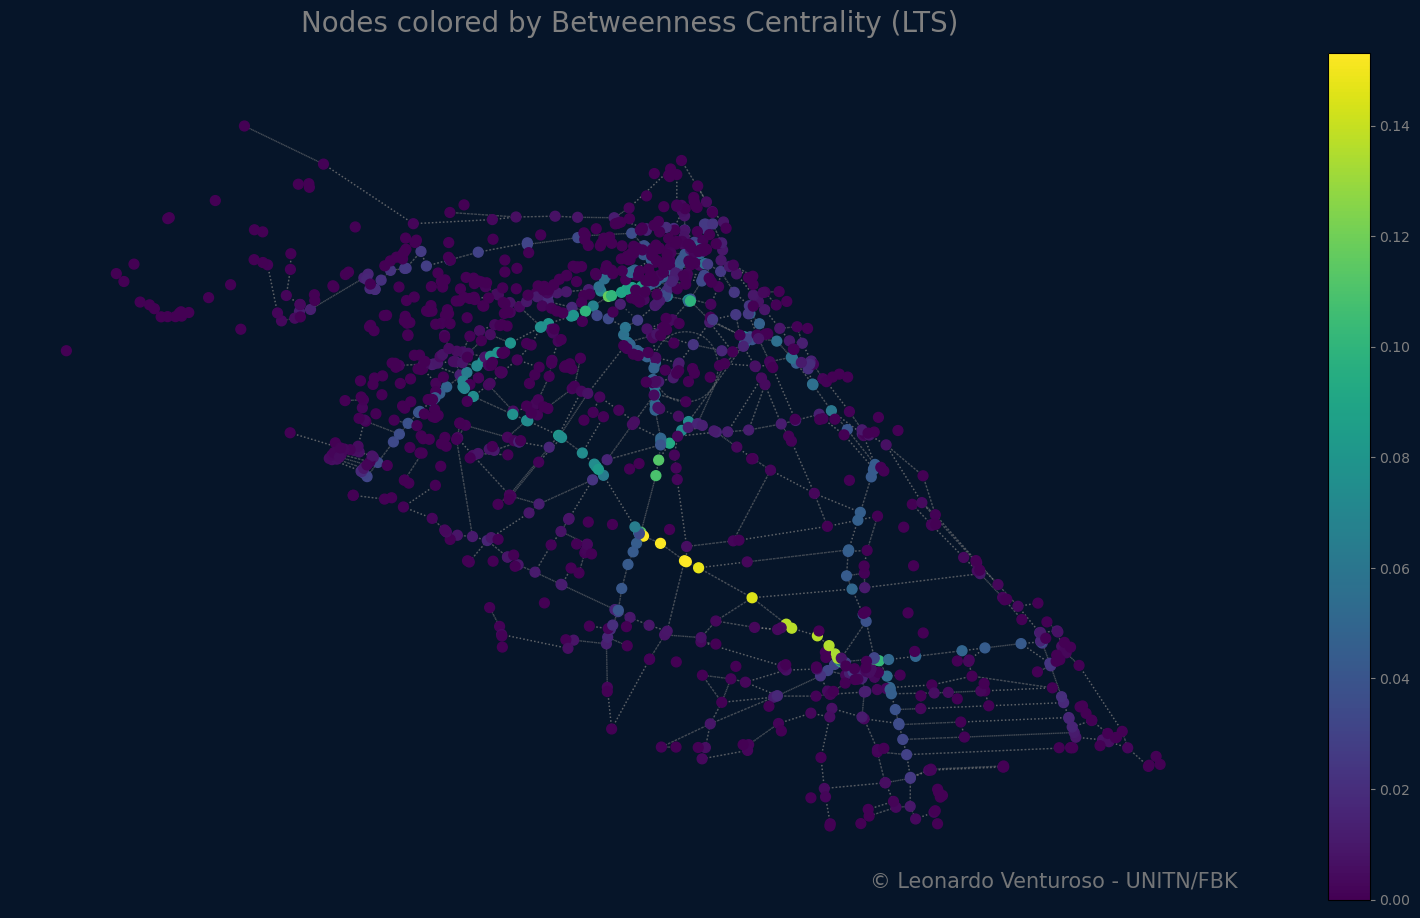

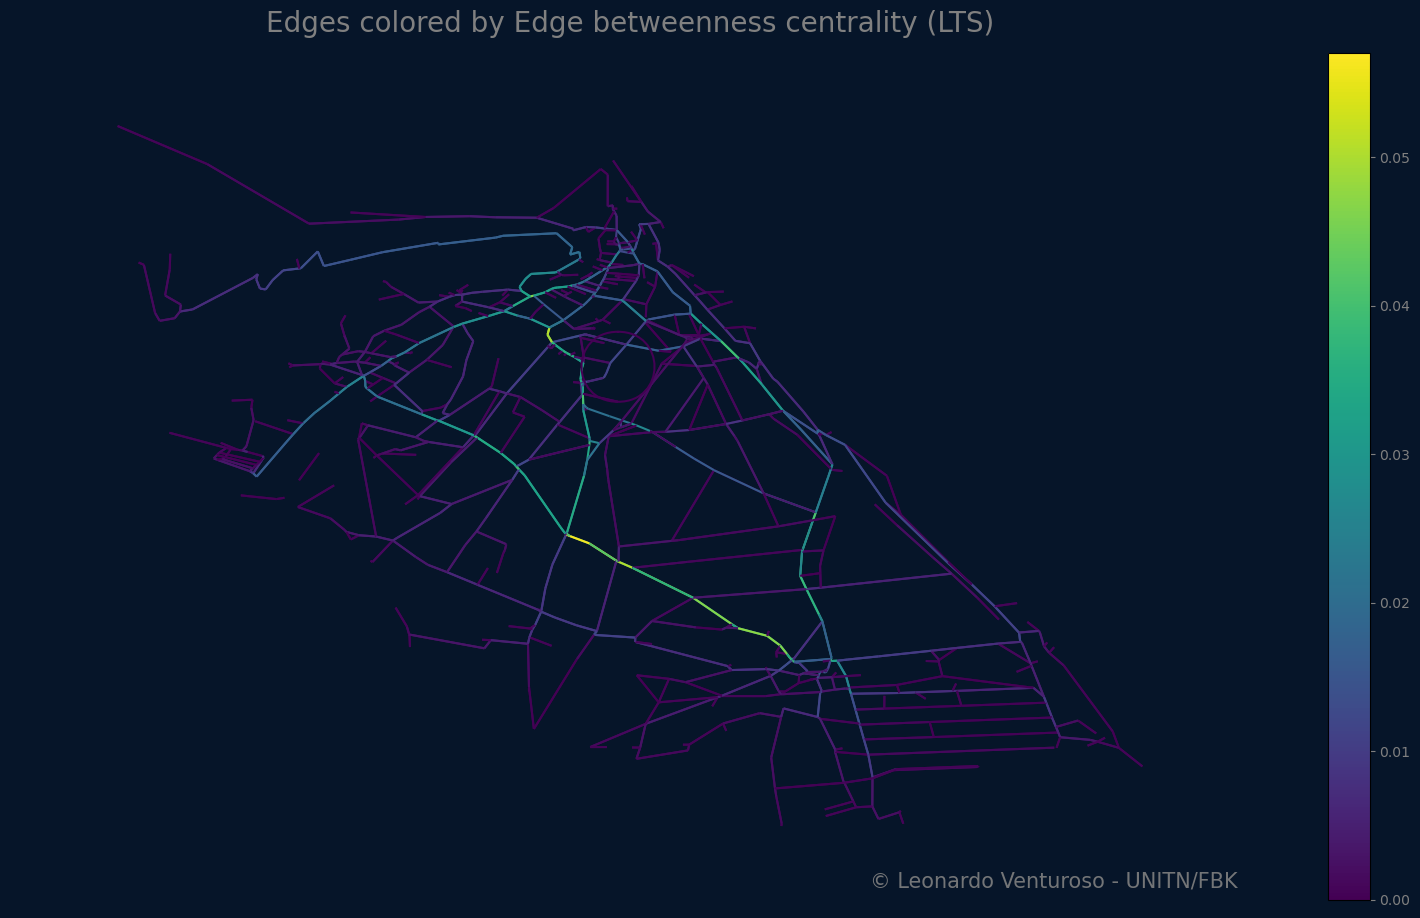

In [4]:
## Graphs for viz of centrality
    
## Visualize nodes based on Degree Centrality (LTS weighted)
draw_graph(G_lts, degree_centrality, 'Nodes colored by Degree Centrality (LTS)')

## Visualize nodes based on Closeness Centrality (LTS weighted)
draw_graph(G_lts, closeness_centrality, 'Nodes colored by Closeness Centrality (LTS)')

## Visualize nodes based on Betweenness Centrality (LTS weighted)
draw_graph(G_lts, betweenness_centrality, 'Nodes colored by Betweenness Centrality (LTS)')

## Visualize edges based on Edges Betweenness Centrality (LTS weighted)
fixed_edge_betweenness = {(u, v): value for (u, v, *_), value in edge_betweenness_centrality_values.items()}
draw_edges(G_lts, fixed_edge_betweenness, "Edges colored by Edge betweenness centrality (LTS)")

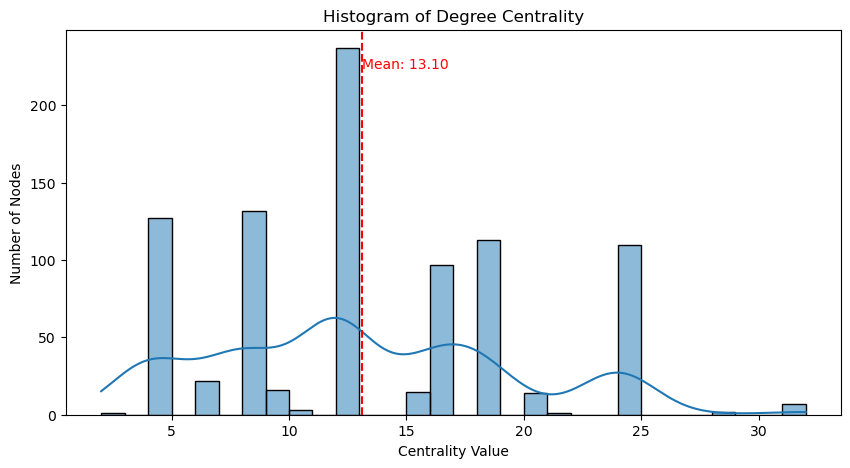

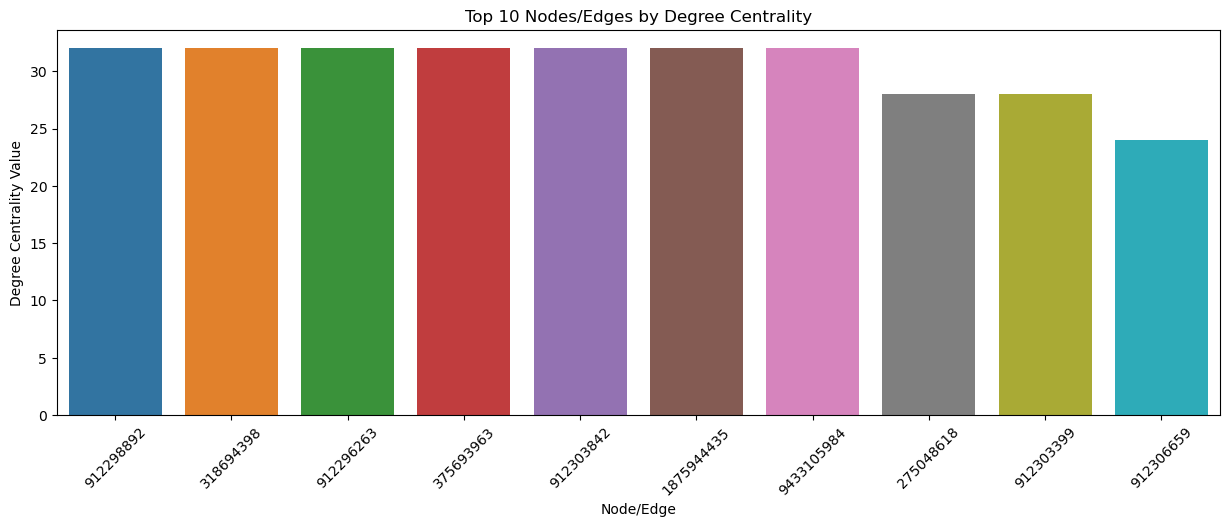

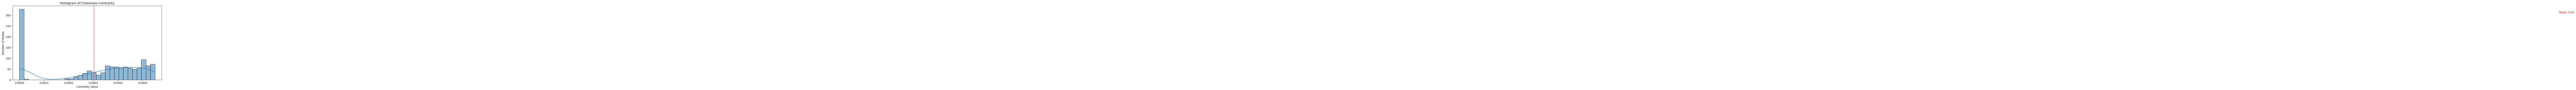

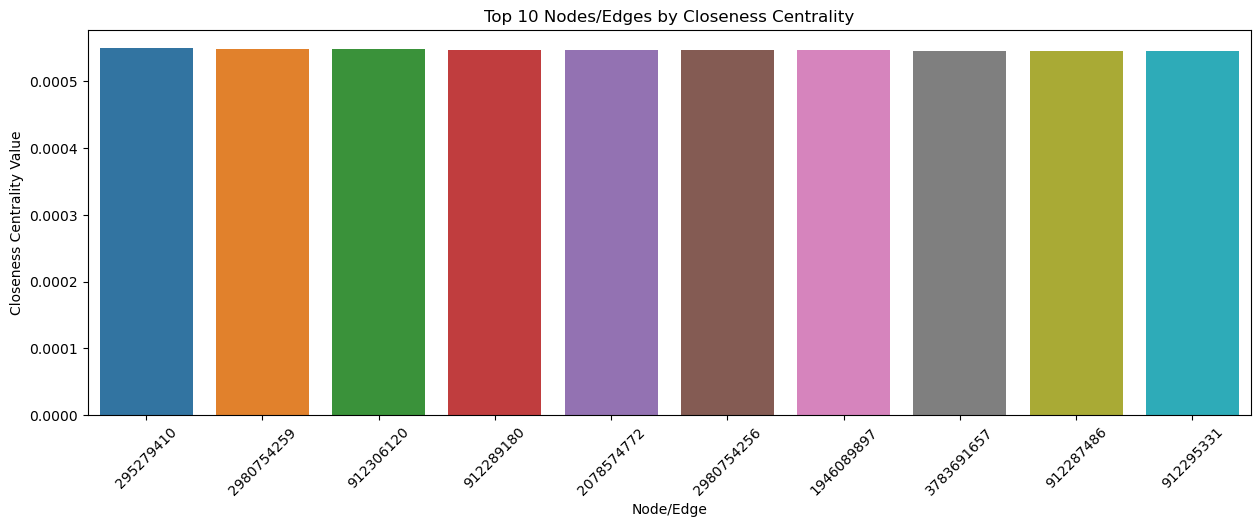

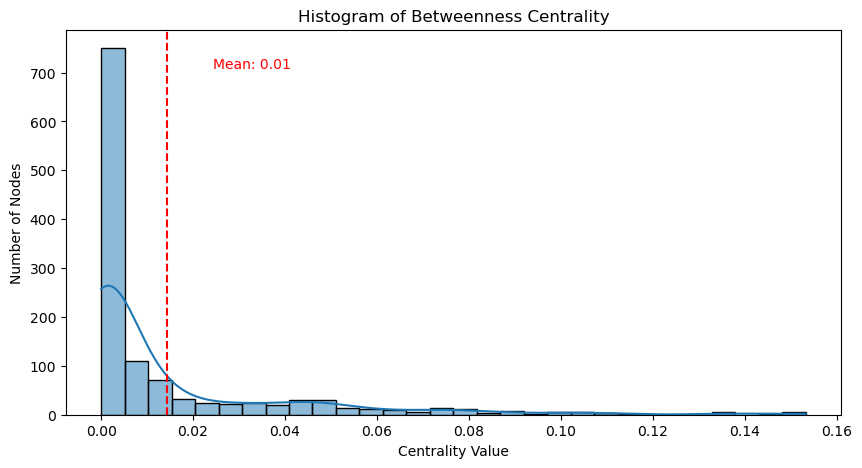

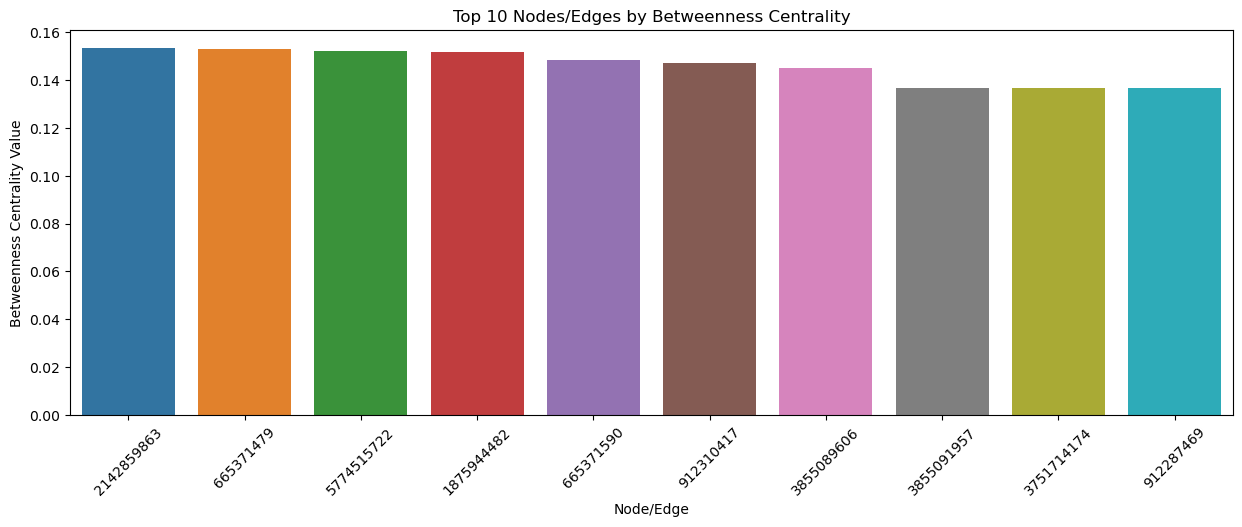

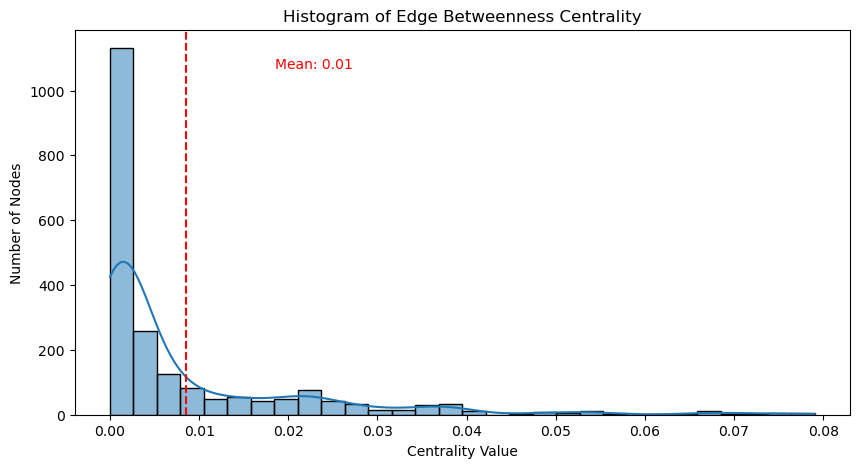

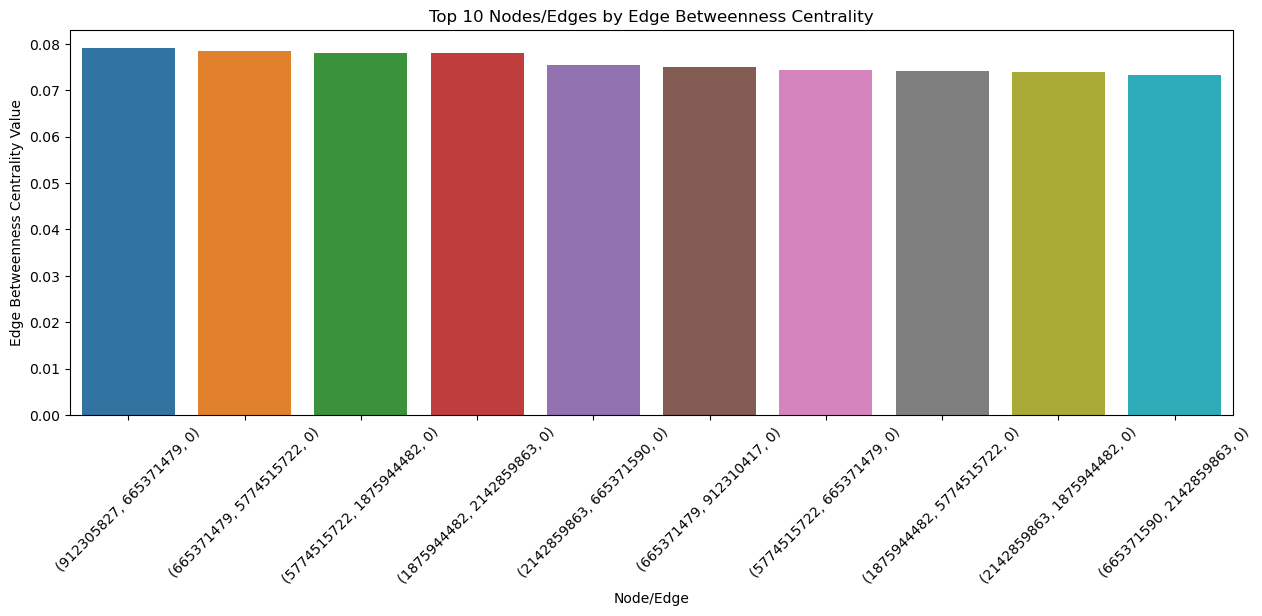

In [5]:
## Histograms for viz of centrality measures to understand the distribution of centrality scores across nodes.
## Bar plots for the top nodes in each centrality measure.

## Function to visualize centrality measures
def visualize_centrality(centrality_values, title):
    ## Histogram
    plt.figure(figsize=(10, 5))
    sns.histplot(list(centrality_values.values()), bins=30, kde=True)

    # Display mean value
    mean_value = np.mean(list(centrality_values.values()))
    plt.axvline(mean_value, color='red', linestyle='--')
    plt.text(mean_value + 0.01, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_value:.2f}', color='red', rotation=0)
    
    plt.title(f'Histogram of {title}')
    plt.xlabel('Centrality Value')
    plt.ylabel('Number of Nodes')
    plt.show()

    ## Bar plot for top nodes
    top_nodes = sorted(centrality_values.items(), key=lambda x: x[1], reverse=True)[:10]
    nodes, values = zip(*top_nodes)
    
    # Convert nodes (which can be tuples for edges) to strings for visualization
    nodes = [str(node) for node in nodes]
    
    plt.figure(figsize=(15, 5))
    sns.barplot(list(nodes), list(values))
    plt.title(f'Top 10 Nodes/Edges by {title}')
    plt.xlabel('Node/Edge')
    plt.ylabel(f'{title} Value')
    plt.xticks(rotation=45)
    plt.show()

## Visualize Degree Centrality
visualize_centrality(degree_centrality, 'Degree Centrality')

## Visualize Closeness Centrality
visualize_centrality(closeness_centrality, 'Closeness Centrality')

## Visualize Betweenness Centrality
visualize_centrality(betweenness_centrality, 'Betweenness Centrality')

## Visualize Edge Betweenness Centrality
visualize_centrality(edge_betweenness_centrality, 'Edge Betweenness Centrality')

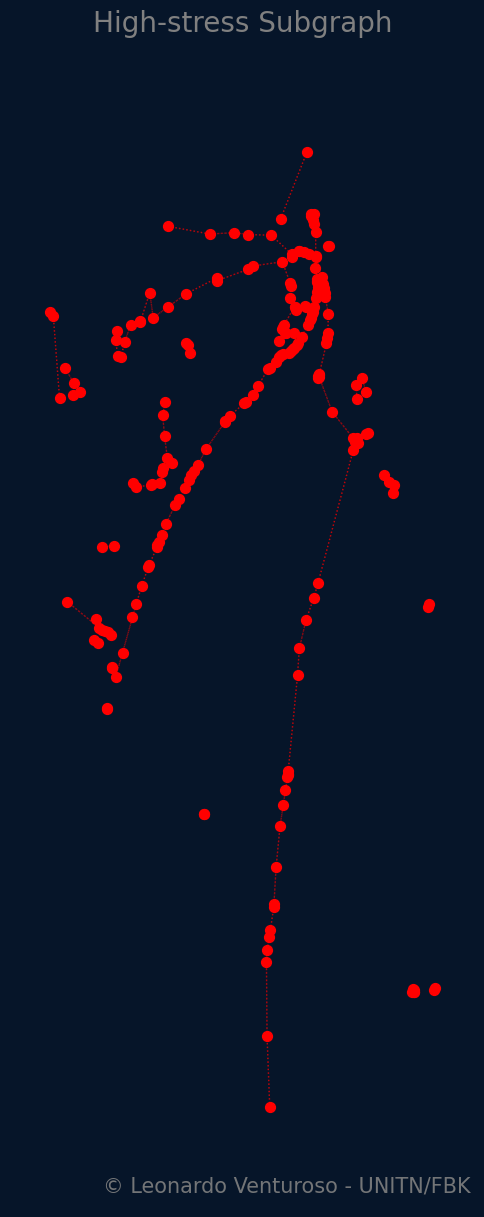

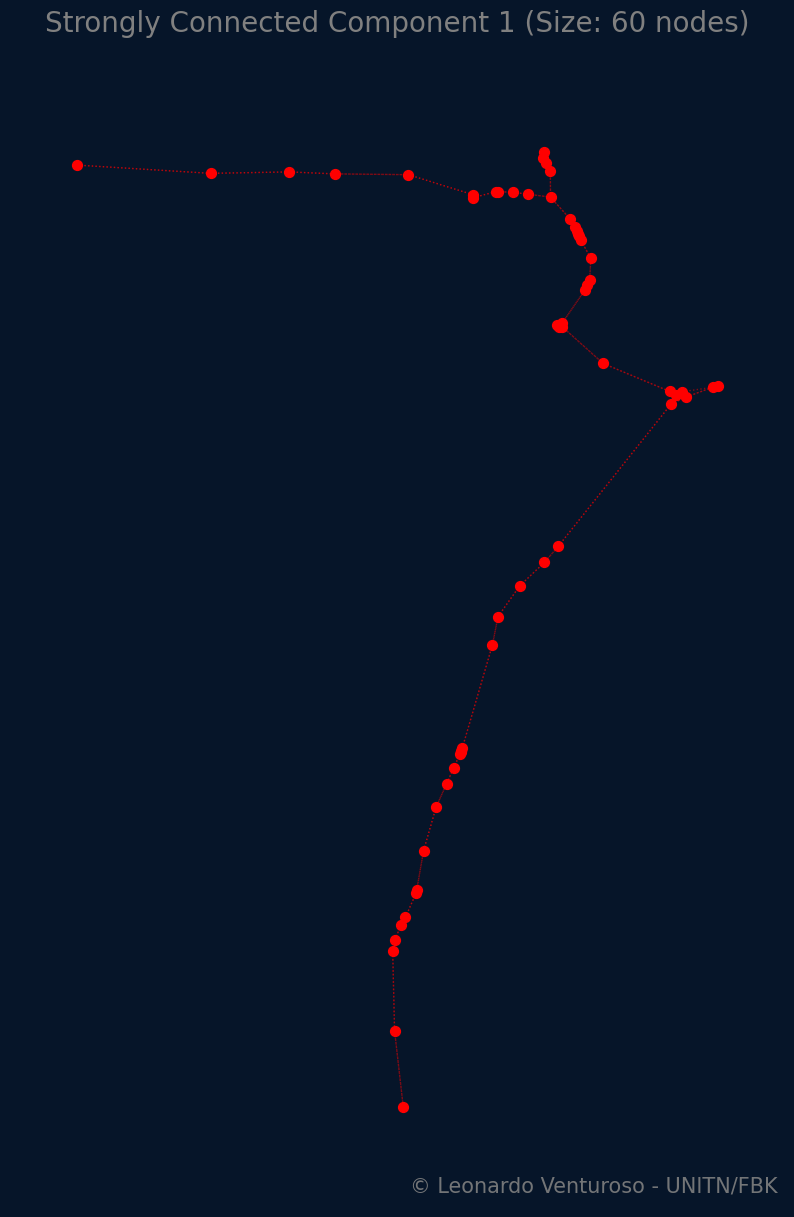

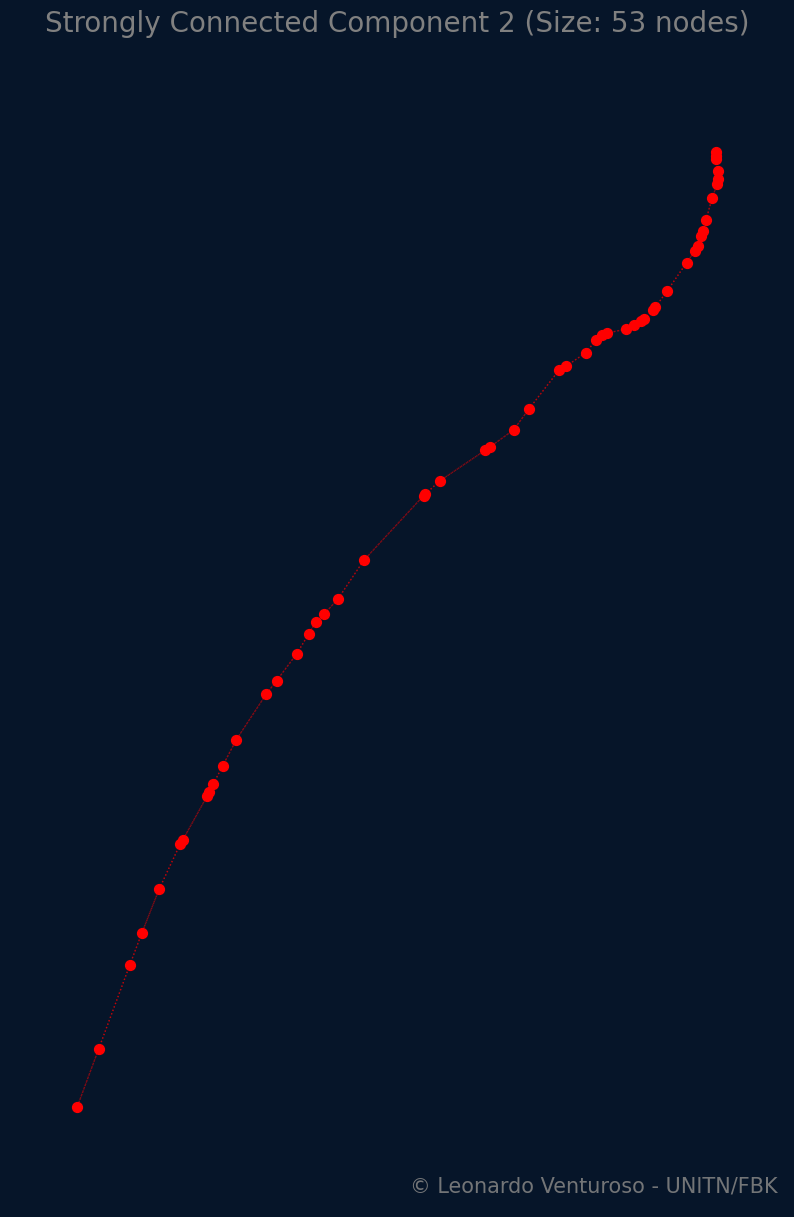

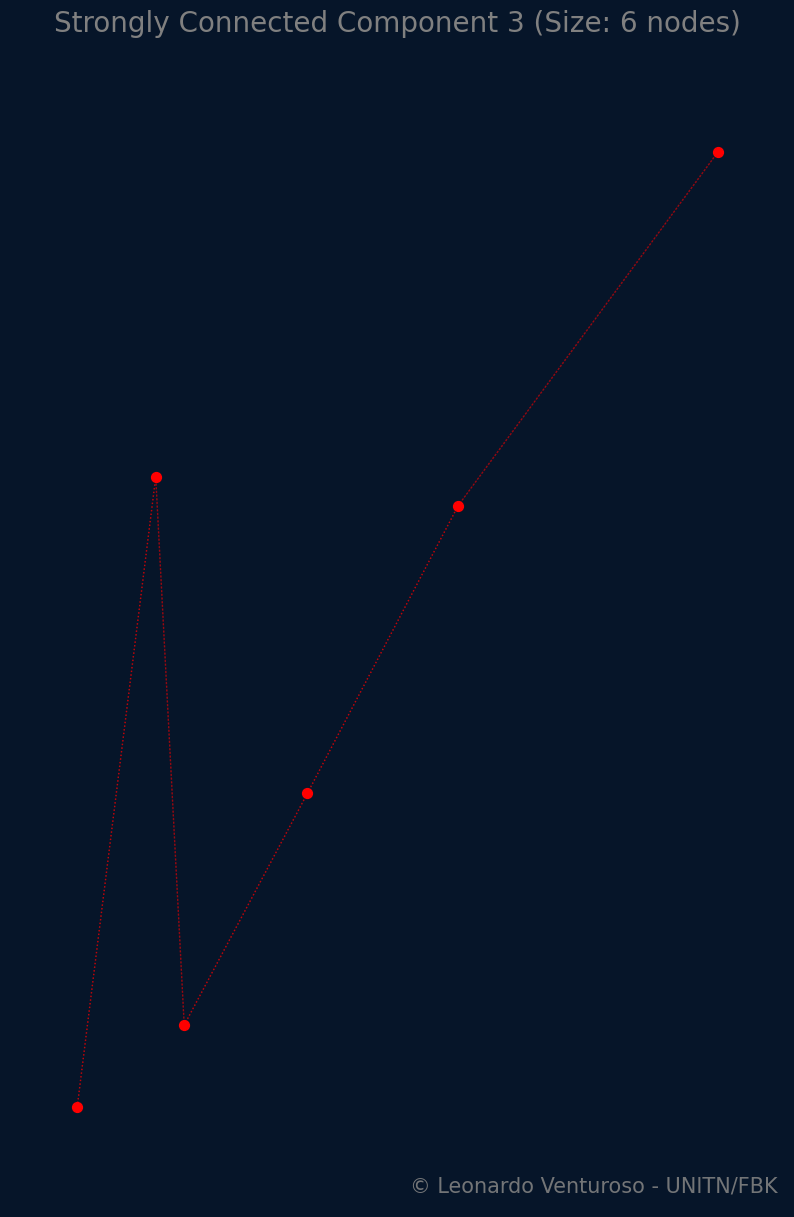

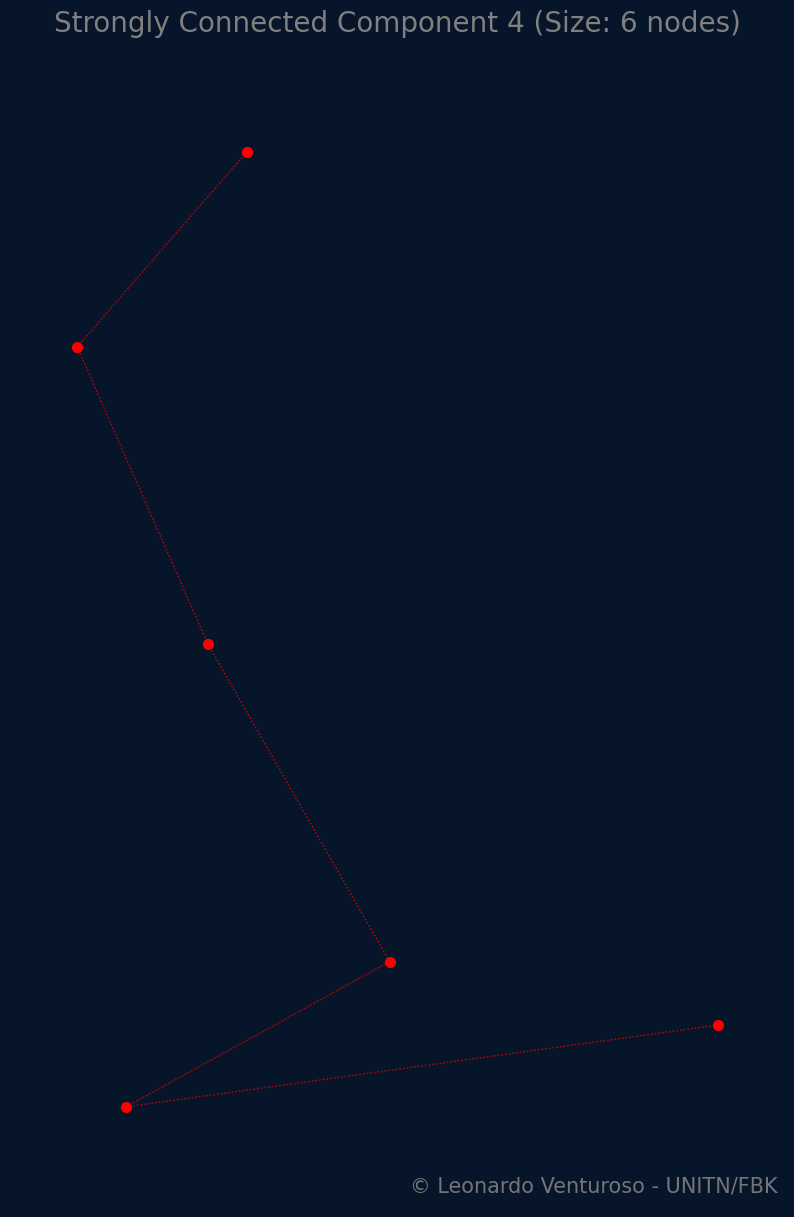

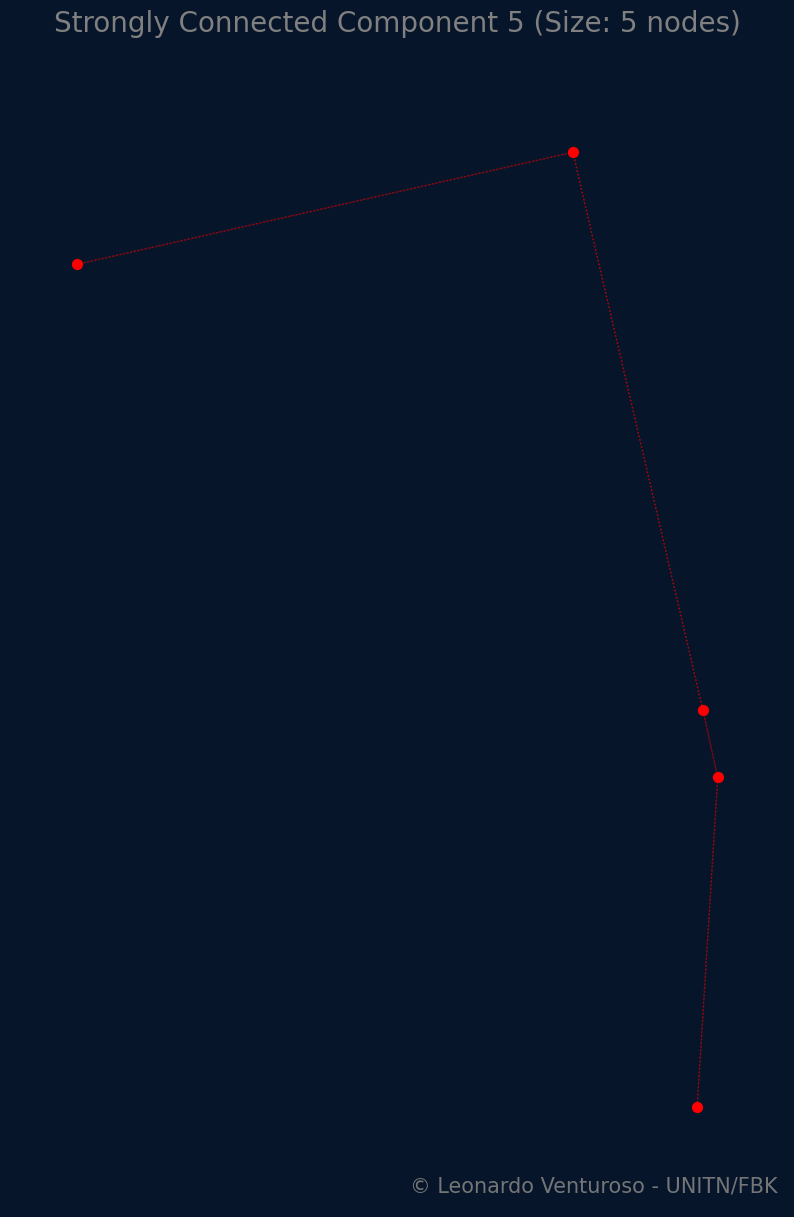

In [6]:
## Graphs for visualizing the SCC and high-stress subgraphs.
 
def visualize_high_stress_subgraph(subgraph):
    """
    Visualizes the high-stress subgraph with a specified style.
    """
    # Use geographical coordinates for positioning
    pos = {node: (data['x'], data['y']) for node, data in subgraph.nodes(data=True)}

    # Figure setup
    fig, ax = plt.subplots(figsize=(6, 15))
    ax.set_facecolor("#061529")
    fig.set_facecolor("#061529")

    # Draw nodes and edges
    nx.draw_networkx_nodes(G=subgraph, pos=pos, node_color="red", alpha=1, node_size=50)
    nx.draw_networkx_edges(G=subgraph, pos=pos, edge_color='red', style="dotted", alpha=0.5, arrows=False)

    # Labeling Axes
    ax.set_title("High-stress Subgraph", fontdict={"fontsize": 20, "color": "grey"}, pad=15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Leonardo Venturoso - UNITN/FBK',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha=0.9)

    plt.show()

def visualize_largest_strongly_connected_components(components, G, n=5):
    """
    Visualizes the top n largest strongly connected components of the graph with a specified style.
    """
    # Sort the components by size in descending order
    sorted_components = sorted(components, key=len, reverse=True)

    # Use geographical coordinates for positioning
    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

    for i, component in enumerate(sorted_components[:n]):
        subgraph = G.subgraph(component)

        # Figure setup
        fig, ax = plt.subplots(figsize=(10, 15))
        ax.set_facecolor("#061529")
        fig.set_facecolor("#061529")

        # Draw nodes and edges
        nx.draw_networkx_nodes(G=subgraph, pos=pos, node_color="red", alpha=1, node_size=50)
        nx.draw_networkx_edges(G=subgraph, pos=pos, edge_color='red', style="dotted", alpha=0.5, arrows=False)

        # Labeling Axes
        ax.set_title(f"Strongly Connected Component {i + 1} (Size: {len(component)} nodes)", fontdict={"fontsize": 20, "color": "grey"}, pad=15)
        ax.axis('off')

        # Watermark
        ax.text(0.99, 0.01, '© Leonardo Venturoso - UNITN/FBK',
                verticalalignment='bottom',
                horizontalalignment='right',
                transform=ax.transAxes,
                color='grey',
                fontsize=15,
                alpha=0.9)

        plt.show()

visualize_high_stress_subgraph(G_high_stress)
visualize_largest_strongly_connected_components(high_stress_subgraphs, G_high_stress)